# Train your player

This notebook will give a concrete example on how to train an agent for Quarto using Q-learning.
At the end, it will also show how to submit your implementation to the arena.

In [1]:
# Imports

from quarto.environment import Environment
from quarto.base_player import RandomPlayer, DummyPlayer
from quarto.train import train, run_duel
from collections import deque
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F


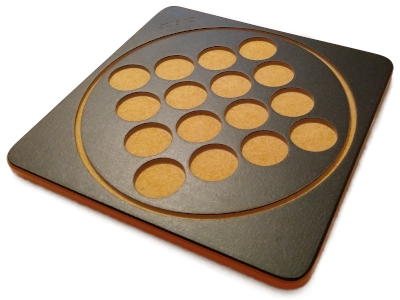
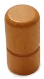
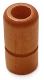
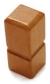
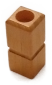
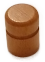
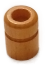
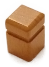
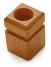
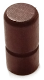
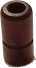
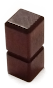
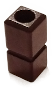
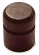
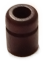
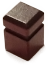
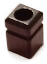

In [2]:
# Create environment

env = Environment()
env

In [3]:
class QNetwork(nn.Module):
    """
    The Q-network with two hidden layers, taking as input the current state
    (see details on the encoding below) and outputs the Q-value for each action,
    even the invalid ones
    """

    def __init__(self, state_size, action_size, hidden_1_size, hidden_2_size):
        super().__init__()
        
        self.hidden_layer = nn.Linear(state_size, hidden_1_size)
        self.hidden_layer2 = nn.Linear(hidden_1_size, hidden_2_size)
        self.output_layer = nn.Linear(hidden_2_size, action_size)

    def forward(self, state):
        x = F.relu(self.hidden_layer(state))
        x = F.relu(self.hidden_layer2(x))
        return self.output_layer(x)

In [4]:
class ReplayMemory:
    """
    A fixed-size buffer to store recent player experience
    """

    def __init__(self, memory_size):
        # A wrapping list of tuples like: (state, action, reward, next_state, done)
        self.memory = deque(maxlen=memory_size)

    def append(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=batch_size)

        # Concat values as torch tensors
        states = torch.stack([exp[0] for exp in experiences]).float()
        actions = torch.Tensor([exp[1] for exp in experiences]).long()
        rewards = torch.Tensor([exp[2] for exp in experiences]).float()
        next_states = torch.stack([exp[3] for exp in experiences]).float()
        dones = torch.Tensor([exp[4] for exp in experiences]).float()

        return states, actions, rewards, next_states, dones

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [5]:
class DeepQAgent:
    def __init__(self,
                 state_size, action_size, hidden_1_size, hidden_2_size,
                 encode_state_fn,
                 memory_size=int(1e5),
                 batch_size=128,
                 train_every=5,
                 epsilon=1, min_epsilon=0.1, epsilon_decay=0.99995,
                 tau=5e-4, gamma=1,
                 lr=1e-4):
        # Local Q-network => used to play and directly trained
        self.state_size = state_size
        self.action_size = action_size
        self.hidden_1_size = hidden_1_size
        self.hidden_2_size = hidden_2_size
        self.qnetwork_local = QNetwork(state_size, action_size, hidden_1_size, hidden_2_size)
        self.loss = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.qnetwork_local.parameters(), lr=lr)

        # Target Q-network => softly trained
        self.qnetwork_target = QNetwork(state_size, action_size, hidden_1_size, hidden_2_size)
        self.qnetwork_target.eval()
        
        # Epsilon scheduling
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.epsilon_decay = epsilon_decay
        
        # Q-network update hyperparameters
        self.tau = tau
        self.gamma = gamma
        
        self.batch_size = batch_size
        self.memory = ReplayMemory(memory_size)
        self.step_count = 0
        self.encode_state_fn = encode_state_fn
        self.train_every = train_every
        self.prev_action = None
        self.prev_state = None
        
    def start(self, state, valid_actions):
        state = self.encode_state_fn(state)
        self.prev_state = state
        self.prev_action = self._take_action(state, valid_actions)
        return self.prev_action

    def step(self, state, valid_actions, reward):
        state = self.encode_state_fn(state)
        self._save_step(self.prev_state, self.prev_action, reward, state, False)
        self.prev_state = state
        self.prev_action = self._take_action(state, valid_actions)
        return self.prev_action

    def end(self, state, reward):
        state = self.encode_state_fn(state)
        self._save_step(self.prev_state, self.prev_action, reward, state, True)
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

    def _take_action(self, state, valid_actions):
        if random.random() < self.epsilon:
            # Random action
            return random.choice(valid_actions)
        else:
            # Chose the action with the highest Q-value estimated by the local network
            self.qnetwork_local.eval()
            with torch.no_grad():
                action_values = self.qnetwork_local(state.unsqueeze(0)).numpy()[0]
            self.qnetwork_local.train()
            valid_action_values = action_values[valid_actions]
            return valid_actions[np.argmax(valid_action_values)]

    def _save_step(self, prev_state, prev_action, reward, state, done):
        # Save experience in replay memory
        self.memory.append(prev_state, prev_action, reward, state, done)

        # Check if will learn from a batch
        self.step_count += 1
        if self.step_count % self.train_every == 0 and len(self.memory) >= self.batch_size:
            states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

            # Calculate max_a(Q) for all samples using the target network
            with torch.no_grad():
                maxQ, _ = self.qnetwork_target(next_states).max(dim=1)
            maxQ = maxQ.unsqueeze(-1)

            # Calculate target values
            targets = rewards + self.gamma * (1 - dones) * maxQ

            # Optimize
            all_action_values = self.qnetwork_local(states)
            values = all_action_values.index_select(1, actions)
            loss = self.loss(values, targets)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # Do a soft update of the weights in the target network
            for target_param, local_param in zip(self.qnetwork_target.parameters(), self.qnetwork_local.parameters()):
                target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)
        
    def get_freezed(self):
        # Return a copy of the player, but not in train_mode
        # This is used by the training loop, to replace the adversary from time to time
        return TrainedDQAgent(
            self.state_size, self.action_size,
            self.hidden_1_size, self.hidden_2_size,
            self.qnetwork_local.state_dict(), self.encode_state_fn)

    def save(self):
        # Save the q-table on the disk for future use
        torch.save(self.qnetwork_local.state_dict(), f'dq-player-{self.step_count}.pth')

In [6]:
class TrainedDQAgent:
    def __init__(self, state_size, action_size, hidden_1_size, hidden_2_size, state_dict, encode_state_fn):
        self.qnetwork = QNetwork(state_size, action_size, hidden_1_size, hidden_2_size)
        self.qnetwork.load_state_dict(state_dict)
        self.qnetwork.eval()
        self.encode_state_fn = encode_state_fn
        
    def start(self, state, valid_actions):
        return self._take_action(self.encode_state_fn(state), valid_actions)
        
    def step(self, state, valid_actions, reward):
        return self._take_action(self.encode_state_fn(state), valid_actions)

    def end(self, state, reward):
        pass
    
    def _take_action(self, state, valid_actions):
        # Chose the action with the highest Q-value estimated by the local network
        with torch.no_grad():
            action_values = self.qnetwork(state.unsqueeze(0)).numpy()[0]
        valid_action_values = action_values[valid_actions]
        return valid_actions[np.argmax(valid_action_values)]

In [7]:
# Train the agent

def encode_state_fn(state):
    # Encode the state as a one-hot encoding of the position of each one of the 16 pieces,
    # representing each one with a 17-element vector, where the first 16 represent a position
    # in the board and the last the reserve. If the piece is not yet in game, it will be
    # represented by the zero vector, that is, 17 zeros
    piece_is_there = np.concatenate([state == piece for piece in range(16)])
    return torch.Tensor(piece_is_there.astype('float'))

player = DeepQAgent(state_size=16*17, action_size=16*16,
                    hidden_1_size=512, hidden_2_size=512,
                    encode_state_fn=encode_state_fn)

def on_cycle_end(cycle):
    print(f'epsilon={player.epsilon}')

train(env, player, train_episodes=2000, on_cycle_end=on_cycle_end, cycles=1000, eval_player=RandomPlayer(False))

Cycle 1/1000: avg train score = 3.75, avg eval score = 8.0
epsilon=0.9048351558698455
Cycle 2/1000: avg train score = -9.65, avg eval score = 0.8
epsilon=0.8187266592980071
Cycle 3/1000: avg train score = -0.2, avg eval score = 5.4
epsilon=0.7408126643807084
Cycle 4/1000: avg train score = -2.7, avg eval score = 8.9
epsilon=0.6703133426452752
Cycle 5/1000: avg train score = -5.5, avg eval score = 23.9
epsilon=0.6065230778740716
Cycle 6/1000: avg train score = -10.3, avg eval score = 18.9
epsilon=0.5488034037068446
Cycle 7/1000: avg train score = -4.25, avg eval score = 30.1
epsilon=0.4965766133349839
Cycle 8/1000: avg train score = -8.3, avg eval score = 33.6
epsilon=0.44931997732828144
Cycle 9/1000: avg train score = -6.9, avg eval score = 30.8
epsilon=0.4065605117212704
Cycle 10/1000: avg train score = -7.25, avg eval score = 26.4
epsilon=0.36787024399384166
Cycle 11/1000: avg train score = -3.95, avg eval score = 32.8
epsilon=0.3328619295640452
Cycle 12/1000: avg train score = 1.55,

Cycle 109/1000: avg train score = -0.4, avg eval score = -6.7
epsilon=0.1
Cycle 110/1000: avg train score = -3.05, avg eval score = 9.3
epsilon=0.1
Cycle 111/1000: avg train score = -0.2, avg eval score = 2.2
epsilon=0.1
Cycle 112/1000: avg train score = -1.65, avg eval score = -1.2
epsilon=0.1
Cycle 113/1000: avg train score = 5.45, avg eval score = 0.3
epsilon=0.1
Cycle 114/1000: avg train score = 6.15, avg eval score = -2.6
epsilon=0.1
Cycle 115/1000: avg train score = -1.95, avg eval score = 0.0
epsilon=0.1
Cycle 116/1000: avg train score = -0.3, avg eval score = -0.9
epsilon=0.1
Cycle 117/1000: avg train score = -1.55, avg eval score = -14.9
epsilon=0.1
Cycle 118/1000: avg train score = -2.25, avg eval score = 5.0
epsilon=0.1
Cycle 119/1000: avg train score = -1.6, avg eval score = 7.4
epsilon=0.1
Cycle 120/1000: avg train score = -0.5, avg eval score = -3.1
epsilon=0.1
Cycle 121/1000: avg train score = 2.4, avg eval score = -1.1
epsilon=0.1
Cycle 122/1000: avg train score = -2.55

Cycle 221/1000: avg train score = 0.95, avg eval score = 10.2
epsilon=0.1
Cycle 222/1000: avg train score = -1.65, avg eval score = 4.7
epsilon=0.1
Cycle 223/1000: avg train score = 2.55, avg eval score = 2.8
epsilon=0.1
Cycle 224/1000: avg train score = 4.6, avg eval score = 9.6
epsilon=0.1
Cycle 225/1000: avg train score = -0.3, avg eval score = 2.4
epsilon=0.1
Cycle 226/1000: avg train score = 2.05, avg eval score = 3.0
epsilon=0.1
Cycle 227/1000: avg train score = 0.0, avg eval score = 9.3
epsilon=0.1
Cycle 228/1000: avg train score = 9.0, avg eval score = 4.3
epsilon=0.1
Cycle 229/1000: avg train score = 3.0, avg eval score = 12.4
epsilon=0.1
Cycle 230/1000: avg train score = 3.1, avg eval score = 0.2
epsilon=0.1
Cycle 231/1000: avg train score = -2.55, avg eval score = 6.7
epsilon=0.1
Cycle 232/1000: avg train score = 11.1, avg eval score = -3.4
epsilon=0.1
Cycle 233/1000: avg train score = 0.15, avg eval score = 23.5
epsilon=0.1
Cycle 234/1000: avg train score = -11.8, avg eval 

Cycle 333/1000: avg train score = 2.25, avg eval score = -4.4
epsilon=0.1
Cycle 334/1000: avg train score = 5.7, avg eval score = 0.1
epsilon=0.1
Cycle 335/1000: avg train score = 3.95, avg eval score = -8.7
epsilon=0.1
Cycle 336/1000: avg train score = -3.0, avg eval score = -1.3
epsilon=0.1
Cycle 337/1000: avg train score = -7.4, avg eval score = 1.7
epsilon=0.1
Cycle 338/1000: avg train score = 7.2, avg eval score = -4.2
epsilon=0.1
Cycle 339/1000: avg train score = -18.65, avg eval score = -7.8
epsilon=0.1
Cycle 340/1000: avg train score = -2.2, avg eval score = -4.5
epsilon=0.1
Cycle 341/1000: avg train score = -4.15, avg eval score = 4.1
epsilon=0.1
Cycle 342/1000: avg train score = -0.5, avg eval score = -1.9
epsilon=0.1
Cycle 343/1000: avg train score = 4.3, avg eval score = 2.0
epsilon=0.1
Cycle 344/1000: avg train score = -0.95, avg eval score = -8.8
epsilon=0.1
Cycle 345/1000: avg train score = -2.25, avg eval score = 1.4
epsilon=0.1
Cycle 346/1000: avg train score = -4.95, 

Cycle 445/1000: avg train score = 8.35, avg eval score = -9.9
epsilon=0.1
Cycle 446/1000: avg train score = 5.9, avg eval score = -6.9
epsilon=0.1
Cycle 447/1000: avg train score = 11.9, avg eval score = -3.7
epsilon=0.1
Cycle 448/1000: avg train score = -4.45, avg eval score = -7.8
epsilon=0.1
Cycle 449/1000: avg train score = 11.6, avg eval score = -0.4
epsilon=0.1
Cycle 450/1000: avg train score = 10.85, avg eval score = -9.5
epsilon=0.1
Cycle 451/1000: avg train score = -5.7, avg eval score = -2.8
epsilon=0.1
Cycle 452/1000: avg train score = -1.15, avg eval score = 0.8
epsilon=0.1
Cycle 453/1000: avg train score = 1.45, avg eval score = 12.1
epsilon=0.1
Cycle 454/1000: avg train score = 6.5, avg eval score = 7.9
epsilon=0.1
Cycle 455/1000: avg train score = 9.55, avg eval score = -6.1
epsilon=0.1
Cycle 456/1000: avg train score = 6.45, avg eval score = 1.1
epsilon=0.1
Cycle 457/1000: avg train score = -1.05, avg eval score = 6.6
epsilon=0.1
Cycle 458/1000: avg train score = -16.05

Cycle 556/1000: avg train score = -0.45, avg eval score = -0.6
epsilon=0.1
Cycle 557/1000: avg train score = -9.95, avg eval score = 5.6
epsilon=0.1
Cycle 558/1000: avg train score = -6.4, avg eval score = -3.6
epsilon=0.1
Cycle 559/1000: avg train score = -12.05, avg eval score = 7.1
epsilon=0.1
Cycle 560/1000: avg train score = -4.8, avg eval score = -1.5
epsilon=0.1
Cycle 561/1000: avg train score = -10.95, avg eval score = -5.3
epsilon=0.1
Cycle 562/1000: avg train score = -2.7, avg eval score = 7.8
epsilon=0.1
Cycle 563/1000: avg train score = 1.25, avg eval score = -5.8
epsilon=0.1
Cycle 564/1000: avg train score = -0.25, avg eval score = -9.9
epsilon=0.1
Cycle 565/1000: avg train score = -20.05, avg eval score = -10.3
epsilon=0.1
Cycle 566/1000: avg train score = 12.3, avg eval score = -4.6
epsilon=0.1
Cycle 567/1000: avg train score = -3.65, avg eval score = -7.1
epsilon=0.1
Cycle 568/1000: avg train score = 1.0, avg eval score = -11.5
epsilon=0.1
Cycle 569/1000: avg train scor

KeyboardInterrupt: 

In [ ]:
# Run some players against each other to see how they fare

players = [RandomPlayer(False), DummyPlayer(False), player.get_freezed()]
for i, p1 in enumerate(players):
    for p2 in players[i:]:
        print(p1.__class__.__name__, p2.__class__.__name__, run_duel(env, p1, p2, 1000))

# Submit your player to the arena

1. Write a simple Python file named `player.py` with a class named `Player` that contains your implementation and some extra code to load any saved training data (like the Q-table). You can see a working example in the folder `quarto/submission` is this repo.
  
2. Test your code and create the ZIP with `python -m quarto.prepare_submission`

3. Create your account in https://angers.schoolofai.fr/ and submit your player

In [ ]:
!python -m quarto.prepare_submission

# Tweak the implementation, add more logs, debug, improve, have fun :)

In [ ]:
# TODO